# Transfomer Models

This notebook uses the *transformers* library. It is a unified framework for deploying models and developed by [huggingface](https://huggingface.co/). Among other things, it provides functionality to download, train and run language models. You can find a list of models in the [model hub](https://huggingface.co/models). Note that the model hub also contains large language models often not suitable for local deployment. Instead, it has become common to run LLMs remotely via APIs. We will look into frameworks for this later.

The *transformers* library is commonly used to work with models deployed locally. While this means that we can often not run Large Language Models on consumer-grade hardware, it is perfectly suitable for smaller models such as BERT, which are already quite powerful and perectly suited for a lot of tasks - especially when fine-tuned. If you run the *transformers* library on a more powerful server (e.g. AWS, Google or Azure), however, it allows you to run very large models. We will look into deploying quantized LLMs, which circumvent some of these limitations, later.

In [1]:
from transformers import BertTokenizer, BertModel

# define the model name here for convenience
MODEL_NAME = 'bert-base-uncased'

# load model and tokenizer. downloads the model if necessary
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

The *tokenizer* translates the words of a given input to the numbers associated with it by the model. This is necessary, as the actual model only deals in numbers - not text input. This is basically the same mechanism as the `index_to_key` method in our static embeddings before. 

**Important**: tokenizer and model need to match, otherwise the model does not associate the right embeddings with the words!

Let's take a look at the model. Notice how it differentiates between the static word embeddings, additional  embeddings (such as the position in the sequence), and the Encoder. The Attention layer in the Encoder here has 12 stacked  ("BertLayers").


In [2]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

The static word embeddings here have a vocabulary size of 30.522 over 768 embedding dimensions. While it may seem counter-intuitive that BERT has a smaller vocabulary size than the less powerful word2vec model, this can be easily explained: In BERT (and similar models), words are broken town into subwords before embedding. This makes the embedding more flexible and performant, and gives it a better chance at recognizing out-of-vocabulary words!

For example, In Word2Vec, the words "running", "runner", and "runs" would each be separate tokens.
In BERT, these words might be tokenized into subwords like "run", "##ning", "##ner", and "##s", where "##" indicates a subword that is part of a larger word.

### Contextualized Embeddings

Let's see how the BERT model has different embeddings for the same word ("bank") in different contexts

In [3]:
sentences = ["I like water, so I usually walk by the river bank.",
             "I have to go by the bank and withdraw some money."
]

# we need to tokenzie the sentences before feeding them to the 

input = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)

input

{'input_ids': tensor([[  101,  1045,  2066,  2300,  1010,  2061,  1045,  2788,  3328,  2011,
          1996,  2314,  2924,  1012,   102],
        [  101,  1045,  2031,  2000,  2175,  2011,  1996,  2924,  1998, 10632,
          2070,  2769,  1012,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}

*Note*: A "tensor" object is something like a multidimensional matrix. While this is not technically correct, it is mostly used this way in data science. If you want to find out what a tensor actually is, I recommend reading up on linear algebra, or ask somebody knowledgable, like a physicist or mathematician. But be aware that physicists and mathematicians might disagree on the nature of a tensor....

To get the words in the sequence, we need to convert the IDs back to tokens. Note how the tokenizer added special tokens in the process:

In [4]:
tokenizer.convert_ids_to_tokens(input['input_ids'][0])

['[CLS]',
 'i',
 'like',
 'water',
 ',',
 'so',
 'i',
 'usually',
 'walk',
 'by',
 'the',
 'river',
 'bank',
 '.',
 '[SEP]']

In [5]:
tokenizer.convert_ids_to_tokens(input['input_ids'][1])

['[CLS]',
 'i',
 'have',
 'to',
 'go',
 'by',
 'the',
 'bank',
 'and',
 'withdraw',
 'some',
 'money',
 '.',
 '[SEP]',
 '[PAD]']

Note how the tokenizer adds special tokens:
- **[CLS]** (Classification): used as an aggregate representation of the entire sequence. Usually used in classification tasks
- **[SEP]** (Seperator): Seperates parts of the input, here: the two sentences. Indicates the end of a sequence
- **[PAD]** (Padding): Added to pad a sequence to a fixed length. Used to bring all input sequences to the same length for technical reasons. Note how the shorter of the two sentences get a [PAD]


In order to get the actual embeddings, we have to run the input into the model:

In [6]:
import torch

with torch.no_grad(): # torch.no_grad() drops the gradient tracking we'd only need when fine-tuning
    embeddings = model(**input) # this returns the embeddings for each input sequence

len(embeddings)

2

The embeddings consist of two outputs: 

1) The last **hidden states** for each of the input sequences (in our case each of the two sentences), which are the embeddings after passing all the attention layers.

In [7]:
len(embeddings.last_hidden_state)

2

To acces the first sentence's embeddings:

In [8]:
embeddings.last_hidden_state[0] # this is identical to embeddings[0][0]

tensor([[ 0.0853, -0.0994, -0.3272,  ..., -0.1593,  0.2339,  0.5785],
        [ 0.4413, -0.0587, -0.3399,  ..., -0.1189,  0.7490,  0.2191],
        [ 0.0994,  0.6217,  0.7028,  ...,  0.3706,  0.1747,  0.4839],
        ...,
        [ 0.3449, -0.3056,  0.4267,  ..., -0.2619, -0.5350,  0.3470],
        [ 0.5137, -0.0205, -0.3344,  ...,  0.4256, -0.3418, -0.4232],
        [-0.2223, -0.2011, -0.1051,  ...,  0.3117,  0.3677, -0.3390]])

2. The so-called **pooler output**, which is a combined (pooled) representation of the entire input, and usually only used for tasks such as classification

In [9]:
embeddings.pooler_output

tensor([[-0.8573, -0.5435, -0.9416,  ..., -0.8946, -0.7382,  0.9487],
        [-0.7943, -0.3355, -0.7300,  ..., -0.3702, -0.6826,  0.9381]])

When we plot the embeddings for each of the input sentences, we can see that they are indeed quite different for each of the sentences. Notice the different axis ranges as well.

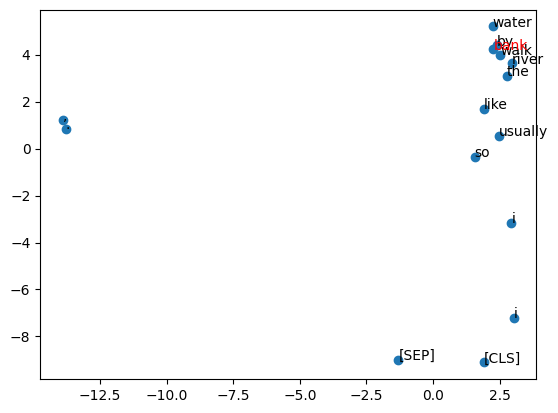

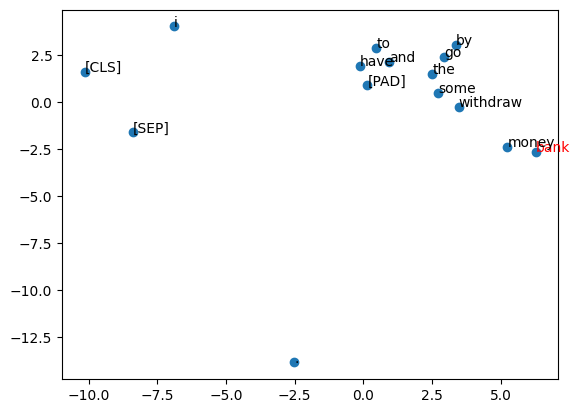

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for i, emb in enumerate(embeddings.last_hidden_state):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(emb)

    plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

    labels = tokenizer.convert_ids_to_tokens(input['input_ids'][i])
    for j, txt in enumerate(labels):
        color = "red" if "bank" in txt else "black"
        plt.annotate(txt, (embeddings_2d[j, 0], embeddings_2d[j, 1]), color = color)

    plt.show()

## Bias

Just like with our static embeddings, our BERT model can have inherent bias due to the data it was trained on. However, as the embeddings are dependant on the context of a word, we cannnot simply check the vector similarity. Instead, we can mask a word in an input sequence and ask the model to return the most likely completion.

Note that this is not a systematic evaluation of the model' biases, but it gives some idea how such an evaluation may be conducted.

In [11]:
# we need a specific model architecture for masked langauge modeling. we can re-use the tokenizer. 
# Note that we still use the same BERT model
from transformers import BertForMaskedLM

mask_model = BertForMaskedLM.from_pretrained(MODEL_NAME)


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [12]:
# Hauke Licht wrote a handy function to get the top-k words for a masked token:

import pandas as pd

def get_topk_words(text):
    
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Get the index of the masked token
    masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

    # Predict the masked token
    with torch.no_grad():
        outputs = mask_model(**inputs)
        predictions = outputs.logits

    # Get the log probabilities of the 10 best fitting words
    log_probs = torch.log_softmax(predictions[0, masked_index], dim=-1)
    top_10_log_probs, top_10_indices = torch.topk(log_probs, 10)

    # Convert indices to tokens
    top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

    # Print the results
    return pd.DataFrame({'token': top_10_tokens, 'log_prob': top_10_log_probs})

In [13]:
get_topk_words("He was really [MASK].")

,token,log_prob
0,good,-1.800818
1,nice,-3.128358
2,cute,-3.288083
3,beautiful,-3.504081
4,happy,-3.606331
5,close,-3.708217
6,hot,-3.829846
7,strong,-3.862879
8,excited,-4.041302
9,scared,-4.181984


In [14]:
get_topk_words("She was really [MASK].")

,token,log_prob
0,good,-2.334454
1,beautiful,-2.970024
2,scared,-3.302579
3,excited,-3.344266
4,happy,-3.374403
5,pretty,-3.531833
6,upset,-3.651014
7,nice,-3.709944
8,cute,-3.802214
9,tired,-3.873873


## Classification

*Important note*: **The strength of the BERT model is not that it is great at any task - as LLMs try to be - but that it is relatively easy to fine-tune it to a specfic task.**

A few pointers on classification tasks:

1) **_Pick the right model for the task._** This means:

    a) **Language**
    Make sure the model "speaks" your language - that is, it was trained on sufficient data for the language you are looking to classify. A lot of smaller models (such as BERT models) are often only trained on English texts. So if you want to, for example, analyze German text data, pick a model that was trained or fine-tuned accordingly. While larger models are often multilingual (that is, trained with data from multiple languages), a smaller model specifically tuned for your input language might still perform better. This is especially  important for less-spoken languages which are more likely to be underrepresented in multilingual model. 
    
    If you are unsure if the model is suitable for your input language, running a couple simple language understanding tasks such as predicting masked-out words can help to give a feeling for its capabilities.

    b) **Task**
    Depending on the complexity of your task, consider using a model specifically tuned for it. While tasks such as sentiment analysis are relatively common, other tasks - say, predicting policy categories - are less straight-forward and may require a more specialized model. Even for tasks such as sentiment analysis, you will need a model that has knowledge of the categories your are trying to predict. This is the case for most large language models, but for smaller models such as BERT, you will one that is tuned to your task. We will look into fine-tuning later, but you should know that *fine-tuning for a specific task often reduces performance in other tasks.*

    You can find a lot of models for different languages and almost any task at the [Hugging Face model hub](https://huggingface.co/models). 

2) **_Evaluate your model output_**
    *Looking at the first few results and deciding that it's good enough is not a proper evaluation*, even though it is often passed as such. In order to gauge if your model is capable of doing your task, you will most likely need to hand-code some of your samples. There are other approaches, such as using a more powerful LLM to judge the model output, but it is highly debatable if this is reliable. *Especially in social science research, you usually want to replicate the expert's - your! - judgement when classifying data!* 
    
    The number of samples you need to code usually depends on the size of your data set and the number of categories you wish to encode. Also consider that human judgement may not be perfect, so you may want to employ multiple coders and evaluate the inter-coder reliability (more on this [here](https://doi.org/10.1080/10584609.2020.1723752)). *Evaluation is especially important when using the results in further analysis steps.* The r² of your regression model is not worth much if the variable labels are only 60% accurate, now is it?


### Sentiment

One of the most common tasks in NLP is sentiment classification. It predicts the sentiment of an input sequence and language models such as BERT are often used for it. However, our out-of-the-box BERT model will actually be quite bad at this, as it never learned what the sentiment labels (e.g. "positive" and "negative") mean. So we'll load up another model better suited for the task.

In [18]:
texts = [
    "I love this product! It's amazing.",
    "This is the worst experience I've ever had.",
    "This thing is quite alright, but really not the best thing ever."
]

For common tasks such as classification, the transformer library comes with a handy shorthand to run the model for your tasks. They are called **pipelines** and take care of almost all the code usually required to run a task and get the results - including tokenization. Very handy!

We can provide a model name to the pipeline. If the task the model was trained for is explicitly stated in the model, the pipeline will know what to do:

In [ ]:
from transformers import pipeline

pipe = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english") # this automatically loads the mode

pipe(texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tim\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998866319656372},
 {'label': 'NEGATIVE', 'score': 0.9997679591178894},
 {'label': 'NEGATIVE', 'score': 0.9982239603996277}]

Note that if you only define a task, e.g. sentiment analysis, the *pipeline* function will use a default model for the task.

**Important:** The default model may not always be what you want, especially if your input is not in English (note how it defaults to an English model!). So it's always better to go to the [model hub](https://huggingface.co/models) and look for a suitable model there.

In [21]:
def_pipe = pipeline("sentiment-analysis")

def_pipe(texts)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998866319656372},
 {'label': 'NEGATIVE', 'score': 0.9997679591178894},
 {'label': 'NEGATIVE', 'score': 0.9982239603996277}]

If the model does not explicitly define a task it was trained for, you may have to both specify the task and the model. For more information on pipelines, see: https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/pipelines

Note that there are also pipelines readily available for data types other than text, such as images or audio.

If you want to run the steps by yourself, rather than using the pipeline, you can do so with the following code:

In [82]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# we need a different tokenizer for the new model
sentiment_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# and load the model
sentiment_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = sentiment_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    logits = sentiment_model(**inputs).logits

for i in range(logits.size(0)):
    probs = torch.softmax(logits[i], dim=0).tolist()
    probs = {sentiment_model.config.id2label[index]: probability for index, probability in enumerate(probs)}
    print(probs)


{'NEGATIVE': 0.00011340079072397202, 'POSITIVE': 0.9998866319656372}
{'NEGATIVE': 0.9997679591178894, 'POSITIVE': 0.00023206845798995346}
{'NEGATIVE': 0.9982239603996277, 'POSITIVE': 0.0017759873298928142}


### Multi-class classification

A more complex task is the classsification of texts into policy categories. A long-running project focused on this is the [Comparative Agendas Project (CAP)](https://www.comparativeagendas.net/). They have been coding different types of text into an elaborate coding scheme, with subprojects for many different countries running for decades. However, so far, they have been doing this qualitatively, with a large number of well-trained coders.

The [poltextLAB](https://poltextlab.com/) has started to use the CAP's extensive collection of hand-coded policy and media texts to train classification models. They provide a vast collection of models for different tasks and languages. Apart from the CAP classification scheme, they also provide models to replicate the [Manifesto Project](https://manifesto-project.wzb.eu/) coding scheme for comparatively analyzing party manifestos, sentiment analysis and emotion analysis. You can find all their models on the model hub: https://huggingface.co/poltextlab

*Note:* While the model use is free, you will need a Hugging Face account and provide the authors with some personal information in order to comply with their fair use guidelines.

**Terminology:** *Multi-class classification* describes the task of sorting an object (here a text) into one of multiple classes (in our case, CAP policy categories). It is assumed that an object can only correctly be sorted into *one* class, not multiple classes. This replicates the CAP coding, as they also only assign one code to a given document. While it is debatable if this is realistic (and a text cannot actually touch in different policy subjects), the task of sorting an object into multiple categories is referred to as *multi-label classification*. It is, however, somewhat more complex and will not be covered here.

In [1]:
# in order to load the Hugging Face access token, we need to load the .env file

from dotenv import load_dotenv

load_dotenv()

True

When processing large data sets, it can be beneficial to utilize your GPU (if available). The CUDA framework is most common and well-implemented, but it requires a NVIDIA GPU. For Mac devices, there is the MPS backend. If neither is available, you can always fall back to using your CPU. The following code automates this setup. By setting the correct 'device'-argument which you can then pass onto your `pipeline` function.

*Note*: Utilizing CUDA requires a specific pytorch installation that comes shipped with CUDA. You can find more info on this here: https://pytorch.org/get-started/locally/. The terminal command `nvidia-smi` returns info on your GPU and, more importantly, the CUDA version you need to install with pytorch. You do *not* need to install CUDA yourself. Note that the CUDA-loaded pytorch installation can be rather large, 2.5gb in my case.

In [2]:
# device setup

import torch

if torch.cuda.is_available(): # CUDA is the preferred device
    device = 'cuda:0'
    print(f'Cuda Found. Running on {torch.cuda.get_device_name(0)}')
else: 
    if torch.backends.mps.is_available(): # MPS backend for Mac
        device = 'mps'
        print('MPS Found. Running on MPS')
    else: 
        device = 'cpu' # fallback to CPU computing
        print('No GPU Found. Running on CPU')

Cuda Found. Running on NVIDIA GeForce GTX 1060 6GB


**Important**: The labels put out by the model are actually incorrect - they are off by one. Unfortunately, this is very badly documented at the model page. However, this becomes clear once you realize that the labels start at 0, but there is no category 0 in the CAP (999 is the "other" category).  Instead, the model classifies macroeconomic topics as LABEL_0, which are CAP category one. Also note that there is no category 11 (nor 22) in the CAP. See: https://www.comparativeagendas.net/pages/master-codebook. 

Therefore, the labels are off by 1, 2 (after 10) or 3 (for LABEL_20) and need to be corrected. We could do this on our labeled data after running the model. However, we can also edit the model's label-id-translation directly, so we do not have to replace the labels everytime we run the model. Note that the "LABEL_" output is only a label added after the model returns a number between 0 and 22 as classification. Therefore, we have to replace the labels assigned to these IDs:

In [55]:
from transformers import AutoModelForSequenceClassification

CAP_NUM_DICT = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', # translates Model Output to CAP Major Policy Codes
6: '7', 7: '8', 8: '9', 9: '10', 10: '12', 11: '13', 12: '14', 
13: '15', 14: '16', 15: '17', 16: '18', 17: '19', 18: '20', 19: 
'21', 20: '23',}

# load the model
cap_model = AutoModelForSequenceClassification.from_pretrained("poltextlab/xlm-roberta-large-english-media-cap-v3")

cap_model.config.id2label = CAP_NUM_DICT # replace the labels with the CAP Major Policy Codes
cap_model.config.label2id = {value: key for key, value in CAP_NUM_DICT.items()} # same for the label2id (reversing the dictionary)

cap_model.config.id2label # inspect the result

{0: '1',
 1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
 8: '9',
 9: '10',
 10: '12',
 11: '13',
 12: '14',
 13: '15',
 14: '16',
 15: '17',
 16: '18',
 17: '19',
 18: '20',
 19: '21',
 20: '23'}

Now we can pass our adjusted model to the `pipeline` function:

In [56]:
from transformers import AutoTokenizer, pipeline
import os

# we need to set the tokenizer, in this case the roberta model the classifier is based on
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large") 

classifier = pipeline(task='text-classification', # make classifier pipeline
                      device=device, # this sets the device we prepared earlier
                      model=cap_model, 
                      tokenizer = tokenizer, 
                      token=os.environ.get("HF_TOKEN")) 

Device set to use cuda:0


We will classify some data I've downloaded from https://www.comparativeagendas.net/datasets_codebooks

We're using a data set on Times of London headlines from 1960 to 2008. Here's what it says on the CAP website about the data:

    The UK media data measures the policy content of the front page of The Times of London. Front page news stories are sampled on the Wednesday of each week between 1960 and 2008, with the headlines blind-coded by two researchers according to major topic code, generating a database of 21,854 front page headlines. Due to important changes in the formatting of The Times during period between 1960 and 2008, along with a strike that stopped production for almost a year we strongly suggest that those interested in the media data refer to the dataset codebook.

In [122]:
import pandas as pd

uk_media = pd.read_csv('data/uk_media.csv')

uk_media.head()

,id,year,speech_year,date,description,subtitle,words,majortopic,filter_international,filter_duplicate
0,1,1960,52,06/01/1960,Engineering Unions Press Pay And Hours Claim,Apparition Of Inflationary Spiral Laid,1042.0,5,0,0
1,2,1960,52,06/01/1960,In Disaster Pit,NaN,796.0,8,0,0
2,3,1960,52,06/01/1960,Peeping Toms,NaN,159.0,12,0,0
3,4,1960,52,06/01/1960,Police Officer Praised For Car Struggle,NaN,173.0,12,0,0
4,5,1960,52,06/01/1960,540 Tugmen End Strike,Employers Agree To Supply Deck Boys,411.0,10,0,0


Note how the headline is actually labeled description. Let's change that, and combine headline and subtitle to give the model a better chance at recognizing the topic.

In [123]:
# we'll combine the two columns and call them "text"
uk_media['text'] = uk_media['description'].fillna('') + ' ' + uk_media['subtitle'].fillna('') # fillna() makes sure missing values don't result in NaN entries

# we'll also drop duplicates indicated by the filter_duplicate column
uk_media = uk_media[uk_media['filter_duplicate'] == 0]

# we'll also drop rows where text is NaN (missing due to missing headlines)
uk_media = uk_media[uk_media['text'].notna()]

uk_media

,id,year,speech_year,date,description,subtitle,words,majortopic,filter_international,filter_duplicate,text
0,1,1960,52,06/01/1960,Engineering Unions Press Pay And Hours Claim,Apparition Of Inflationary Spiral Laid,1042.0,5,0,0,Engineering Unions Press Pay And Hours Claim A...
1,2,1960,52,06/01/1960,In Disaster Pit,NaN,796.0,8,0,0,In Disaster Pit
2,3,1960,52,06/01/1960,Peeping Toms,NaN,159.0,12,0,0,Peeping Toms
3,4,1960,52,06/01/1960,Police Officer Praised For Car Struggle,NaN,173.0,12,0,0,Police Officer Praised For Car Struggle
4,5,1960,52,06/01/1960,540 Tugmen End Strike,Employers Agree To Supply Deck Boys,411.0,10,0,0,540 Tugmen End Strike Employers Agree To Suppl...
...,...,...,...,...,...,...,...,...,...,...,...
21843,21844,2008,102,31/12/2008,State of paranoia all started with a coup - An...,NaN,229.0,26,1,0,State of paranoia all started with a coup - An...
21846,21847,2008,102,31/12/2008,Tribute to Galileo,NaN,62.0,28,0,0,Tribute to Galileo
21849,21850,2008,102,31/12/2008,Dawn chorus dispute,NaN,54.0,12,0,0,Dawn chorus dispute
21850,21851,2008,102,31/12/2008,Dawn chorus dispute,NaN,51.0,12,1,0,Dawn chorus dispute


In [124]:
# distinct majortopic labels, sorted

sorted([int(value) for value in uk_media['majortopic'].unique()]) # the for loop is only here turn the values into native python integers, which print a bit nicer in this case

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 91,
 99]

We can spot a problem with our data set here: The coding seems to be different from the official CAP codes as well! A closer look at the codebooks reveals that codes over 23 are additional, media-specific and dummy codes which were not fed into the model. There is also an additional dummy code of 0 for non-codable articles. For evaluation purposes, we'll drop them.

**You should always make sure your model is compatible with the categories you're using as gold standard!**

In [125]:
# drop rows with majortopic code above 23 and below 1
uk_media = uk_media[uk_media['majortopic'] >= 1]
uk_media = uk_media[uk_media['majortopic'] <= 23]

In [126]:
# test the classifier on the first 10 rows
classifier(list(uk_media['text'][0:9])) # we need to pass the text column as a list

[{'label': '5', 'score': 0.936924159526825},
 {'label': '16', 'score': 0.2734913229942322},
 {'label': '12', 'score': 0.178557351231575},
 {'label': '12', 'score': 0.9686050415039062},
 {'label': '5', 'score': 0.8688399195671082},
 {'label': '12', 'score': 0.21066716313362122},
 {'label': '12', 'score': 0.924317479133606},
 {'label': '10', 'score': 0.9658780097961426},
 {'label': '10', 'score': 0.5852949619293213}]

In [127]:
# classify the whole dataset
classifications = classifier(list(uk_media["text"])) # we need to pass the text column as a list

In [128]:
# as this may take a while we'll safe the classifications locally after the run
# the pickle module can safe and load arbitrary Python objects

import pickle

with open('data/classifications.pkl', 'wb') as f:
    pickle.dump(classifications, f)

In [98]:
# we can then reload the "pickle" file when we need the classifcation results again later

import pickle

with open('data/classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)

In [99]:
# add the classifications to our UK media dataframe

classifications_df = pd.DataFrame(classifications) # turn the classifications a DataFrame

uk_media.reset_index(drop=True, inplace=True) # we need to reset the indices to avoid mismatches
classifications_df.reset_index(drop=True, inplace=True) #  (the classifications index is a fresh one while the uk_media carries missing indices where we removed the data before)

uk_media_classified = pd.concat([uk_media, # combine the two DataFrames
                                 classifications_df], 
                                 axis=1) 

# for evaluation purposes, we'll also turn the majortopic into strings
uk_media_classified['majortopic'] = uk_media_classified['majortopic'].astype(str)

uk_media_classified

,id,year,speech_year,date,description,subtitle,words,majortopic,filter_international,filter_duplicate,text,label,score
0,1,1960,52,06/01/1960,Engineering Unions Press Pay And Hours Claim,Apparition Of Inflationary Spiral Laid,1042.0,5,0,0,Engineering Unions Press Pay And Hours Claim A...,5,0.936924
1,2,1960,52,06/01/1960,In Disaster Pit,NaN,796.0,8,0,0,In Disaster Pit,16,0.273491
2,3,1960,52,06/01/1960,Peeping Toms,NaN,159.0,12,0,0,Peeping Toms,12,0.178557
3,4,1960,52,06/01/1960,Police Officer Praised For Car Struggle,NaN,173.0,12,0,0,Police Officer Praised For Car Struggle,12,0.968605
4,5,1960,52,06/01/1960,540 Tugmen End Strike,Employers Agree To Supply Deck Boys,411.0,10,0,0,540 Tugmen End Strike Employers Agree To Suppl...,5,0.868840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548,21836,2008,102,31/12/2008,Murder charge boys,NaN,64.0,12,0,0,Murder charge boys,12,0.981427
17549,21842,2008,102,31/12/2008,Sir Tom pledges to return clothing chain to pr...,NaN,379.0,15,0,0,Sir Tom pledges to return clothing chain to pr...,15,0.924814
17550,21843,2008,102,31/12/2008,"How small, local and traditional is bucking th...",NaN,813.0,15,0,0,"How small, local and traditional is bucking th...",15,0.709025
17551,21850,2008,102,31/12/2008,Dawn chorus dispute,NaN,54.0,12,0,0,Dawn chorus dispute,3,0.617270


## Evaluation

### Gold Standard
Let's take a look how well our model did. Luckily, the UK Media Dataset comes with labels annotated by trained human coders. This is often referred to as the *Gold Standard*, meaning it will be the standard our model will be held to. In other words, our model would be "perfect" if it could perfectly recreate the human coding. It is important to note that even another trained human coder is unlikely to recreate the exact same coding. This is due to differences and errors in human judgement. This is why in qualitative research, we use the measure of intercoder reliability to make sure our human coders have substandial agreement on their coding tasks. There are some debates on the matter (see, for example, [this paper](https://doi.org/10.1177/1609406919899220)) and various way to calculate it (with Krippendorf's Alpha being the most common), but usually you want your intercoder reliability to be above 85%, with values above 65% sometimes being considered acceptable, depending on the task and data. For our model, this means that we can usually accept it if it does not reproduce our gold standard to 100% (sometimes, this can even be a sign of overfitting to the data). 

However, while some researchers argue otherwise, I strongly recommend against using intercoder reliability to judge model output. The main reason for this is that it somewhat relaxes assumptions by calculating the measurement in such a way that the model is considered equally capable of coding the data as a trained human coder. This is simply not the case, as we usually want to find out whether or not our model can meaningfully replicate human coders' judgement. Intercoder reliability is an important tool when producing the gold standard, as it makes sure it is actually a *good* standard, and you should always make use of it when qualitatively coding a data set (even when coding it by yourself, it is good practice to double code a part of your data to make sure your coding is reliable!). But for measuring a model's capabilities, it is strongly adviced to rely on the evaluation metrics developed in the machine learning domain to measure exactly that.

### Accuracy
Accuracy is a very simple measure: it is the percentage of correct predictions out of all predictions made by the model. As a formula: 
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

While this is an important metric, it is often not a very good metric if your classes are imbalanced. Accuracy puts higher emphasis on the majority class, which is often not the one we're interested in. Think of a spam filter which is great at predicting which emails are not spam, but fails at predicting the (much rarer case) of an email actually being spam. This is especially a problem in multi-class classification, as your less-well represented classes are not only harder to predict for the model due to a lack of training data, but its failure to predict them will also not show in your evaluations.

### Precision, Recall, and F1
To overcome these limitations, precision, recall and F1 scores were developed. They rely on the differentiation between True and False Positives and True and False Negatives.

| <a/> | **Predicted Positive** | **Predicted Negative** |
|:--- |:---:|:---:|
| **Observed Positive** | True Positives (TP) | False Negatives (FN) |
| **Observed Negative** | False Positives (FP) | True Negatives (TN) |

- **True Positives (TP)**: The model correctly predicted the positive class.
- **True Negatives (TN)**: The model correctly predicted the negative class.
- **False Positives (FP)**: The model incorrectly predicted the positive class (predicted positive, but the true label was negative).
- **False Negatives (FN)**: The model incorrectly predicted the negative class (predicted negative, but the true label was positive).

### Precision

Precision measures the proportion of True Positives out of all positive predictions made by the model:
$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

That is, it measures how many positive predictions were actually correct. Precision is the preferred metric if the cost of false positives is high. For example, if your spam filter automatically deletes any email it identifies as spam, you will want very high precision so it does not accidentally delete your other emails (false positives).

However, the problem with precision is that conservative estimates fare better, as they produce less false positives. If your spam filter is not flagging a lot of mails as spam to begin with, it will have high precision, but be also not very good at its job.

### Recall
Recall measures the proportion of True Positives correctly identified by the model:
$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

Recall is the preferred metric when the cost of false negatives is high, for example in medical tests or in flagging hate speech detection where you want to err on the side of caution. 

The problem with recall, is opposed to that of precision: you can achieve perfect recall by predicting all labels as positive, thus making sure you do not miss any relevant cases.

Recall is sometimes also called sensitivity - especially in the medical field. 


### F1 Score

The F1 score is the harmoic mean of precision and recall. That is, it gives an even measure for precision and recall, balancing out their respective weaknesses.

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

It is usually a good overview score of how well your model fares. If you do not have specific requirements for your model that make you value either precision or recall more highly (that is, if neither the cost of false negatives nor of false positives is higher), you will usually want to go with the F1 score to judge model performance.

### Baseline

In order to give you a feeling what these values mean: If we want to classify into one of two categories, using a coin flip for a classifier would produce an accuracy, precision, recall and F1 score of 0.5 - that is, there is a 50% chance of predicting the right class. So if your evaluation metrics are below 0.5, you would be better off just flipping a coin. If you have four classes, random chance of predicting the right one would be 25%, and the scores would equally come down to 0.25. 

So you should keep in mind that what is a "good enough" also depends on the number of categories you're trying to predict. However, eventually it depends on your use-case what the critical value for a reliable model is. For social science research, a rule of thumb is that you want your model to be roughly as reliable as human coders, which means values above 0.85 are considered good, but lower values may be acceptable in some cases. But again, this depends on your specific use case and you should think about what it means when, say, your measurements are only correct in two out of three cases (accuracy of 0.65) - and maybe even worse for some less well-represented categories. Can you make meaningful assumptions at this point? Or should you consider using a different method?

### Model Evaluation

While we could calculate all these scores by hand, the scikit-learn library luckily has handy functions to do this for us:

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(uk_media_classified["majortopic"], uk_media_classified["label"])
precision = precision_score(uk_media_classified["majortopic"], uk_media_classified["label"], average="weighted")
recall = recall_score(uk_media_classified["majortopic"], uk_media_classified["label"], average="weighted")
f1 = f1_score(uk_media_classified["majortopic"], uk_media_classified["label"], average="weighted")

print(
    f'Accuracy: {accuracy}\n'
    f'Precision: {precision}\n'
    f'Recall: {recall}\n'
    f'F1: {f1}'
)

c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7516094114966103
Precision: 0.7720333797188088
Recall: 0.7516094114966103
F1: 0.7549872044599232


We even have a handy overview function for all of this together, and print metrics over all classes:

In [130]:
from sklearn.metrics import classification_report

print(classification_report(uk_media_classified["majortopic"], uk_media_classified["label"]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.84      0.72      0.77       784
          10       0.88      0.88      0.88      1747
          12       0.87      0.79      0.83      2507
          13       0.76      0.38      0.51       133
          14       0.80      0.74      0.77       318
          15       0.76      0.55      0.64       871
          16       0.79      0.69      0.74      2568
          17       0.87      0.71      0.78       801
          18       0.74      0.76      0.75       113
          19       0.61      0.81      0.70      2526
           2       0.51      0.53      0.52       139
          20       0.58      0.77      0.66      1328
          21       0.70      0.52      0.59       419
          22       0.00      0.00      0.00         2
          23       0.02      0.67      0.03         3
           3       0.87      0.80      0.84       795
           4       0.84    

c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\nlp_workshop\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i